<a href="https://colab.research.google.com/github/bella-xia/Medical_Image/blob/main/Using_Siamese_Network_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from pickle import load, dump

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import transforms
import cv2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from torchsummary import summary

In [5]:
import random

In [6]:
from tqdm.notebook import tqdm

In [7]:
torch.autograd.set_detect_anomaly(True)

# Load Data

In [8]:
with open('/content/drive/MyDrive/Colab Notebooks/Medical Image/data/df.h5', 'rb') as f:
  df = load(f)

In [9]:
length = len(df)
length

2024

In [10]:
df.head()

,extent_right_numerical,density_right_numerical,extent_left_numerical,density_left_numerical,mRALE Score,img,processed_img,masked,divide
0,4,3,4,2,20,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",64
1,3,3,3,2,15,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",120
2,1,1,1,1,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",137
3,0,0,0,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",132
4,0,0,0,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",137


# self-implemented Inception V3

In [11]:
class ConvolutionBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super(ConvolutionBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.batchNormalization = nn.BatchNorm2d(out_channels)
    self.activation = nn.ReLU()

  def forward(self, x):
    out = self.conv(x)
    out = self.batchNormalization(out)
    out = self.activation(out)
    return out

In [12]:
class StemBlock(nn.Module):
  def __init__(self, img_channels=1):
    super(StemBlock, self).__init__()

    self.conv1 = ConvolutionBlock(in_channels=img_channels, out_channels=32,
                                  kernel_size=3, stride=2, padding=0)
    self.conv2 = ConvolutionBlock(in_channels=32, out_channels=32,
                                  kernel_size=3, stride=1, padding=0)
    self.conv3 = ConvolutionBlock(in_channels=32, out_channels=64,
                                  kernel_size=3, stride=1, padding=1)
    self.conv4 = ConvolutionBlock(in_channels=64, out_channels=80,
                                  kernel_size=3, stride=1, padding=0)
    self.conv5 = ConvolutionBlock(in_channels=80, out_channels=192,
                                  kernel_size=3, stride=1, padding=1)
    self.maxPool = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))

  def forward(self, x):
    out = self.conv3(self.conv2(self.conv1(x)))
    out = self.maxPool(out)
    out = self.conv5(self.conv4(out))
    out = self.maxPool(out)
    return out


In [13]:
class InceptionBlock_A(nn.Module):
  def __init__(self, in_channels, nbr_kernels):
    super(InceptionBlock_A, self).__init__()

    self.branch1 = nn.Sequential(
        ConvolutionBlock(in_channels=in_channels, out_channels=64,
                         kernel_size=1, stride=1, padding=0),
        ConvolutionBlock(in_channels=64, out_channels=96,
                         kernel_size=3, stride=1, padding=1),
        ConvolutionBlock(in_channels=96, out_channels=96,
                         kernel_size=3, stride=1, padding=1)
    )

    self.branch2 = nn.Sequential(
        ConvolutionBlock(in_channels=in_channels, out_channels=48,
                         kernel_size=1, stride=1, padding=0),
        ConvolutionBlock(in_channels=48, out_channels=64,
                         kernel_size=3, stride=1, padding=1)
    )

    self.branch3 = nn.Sequential(
        nn.AvgPool2d(kernel_size=(3, 3), stride=1, padding=1),
        ConvolutionBlock(in_channels=in_channels, out_channels=64,
                         kernel_size=1, stride=1, padding=0)
    )

    self.branch4 = ConvolutionBlock(in_channels=in_channels, out_channels=64,
                                    kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    branch1 = self.branch1(x)
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch4 = self.branch4(x)

    out = torch.cat([branch1, branch2, branch3, branch4], 1)
    return out

In [14]:
class InceptionBlock_B(nn.Module):
  def __init__(self, in_channels, nbr_kernels):

    super(InceptionBlock_B, self).__init__()

    self.branch1 = ConvolutionBlock(in_channels=in_channels, out_channels=192,
                                    kernel_size=1, stride=1, padding=0)

    self.branch2 = nn.Sequential(
        ConvolutionBlock(in_channels=in_channels, out_channels=nbr_kernels,
                         kernel_size=1, stride=1, padding=0),
        ConvolutionBlock(in_channels=nbr_kernels, out_channels=nbr_kernels,
                         kernel_size=(1, 7), stride=1, padding=(0, 3)),
        ConvolutionBlock(in_channels=nbr_kernels, out_channels=192,
                         kernel_size=(7, 1), stride=1, padding=(3, 0))
    )

    self.branch3 = nn.Sequential(
        ConvolutionBlock(in_channels=in_channels, out_channels=nbr_kernels,
                         kernel_size=1, stride=1, padding=0),
        ConvolutionBlock(in_channels=nbr_kernels, out_channels=nbr_kernels,
                         kernel_size=(7, 1), stride=1, padding=(3, 0)),
        ConvolutionBlock(in_channels=nbr_kernels, out_channels=nbr_kernels,
                         kernel_size=(1, 7), stride=1, padding=(0, 3)),
        ConvolutionBlock(in_channels=nbr_kernels, out_channels=nbr_kernels,
                         kernel_size=(7, 1), stride=1, padding=(3, 0)),
        ConvolutionBlock(in_channels=nbr_kernels, out_channels=192,
                         kernel_size=(1, 7), stride=1, padding=(0, 3))
    )

    self.branch4 = nn.Sequential(
        nn.AvgPool2d(kernel_size=(3, 3), stride=1, padding=1),
        ConvolutionBlock(in_channels=in_channels, out_channels=192,
                         kernel_size=1, stride=1, padding=0)
    )

  def forward(self, x):

    branch1 = self.branch1(x)
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch4 = self.branch4(x)

    out = torch.cat([branch1, branch2, branch3, branch4], 1)

    return out

In [15]:
class InceptionBlock_C(nn.Module):
  def __init__(self, in_channels):
    super(InceptionBlock_C, self).__init__()

    self.branch1 = ConvolutionBlock(in_channels, 320, 1, 1, 0)

    self.branch2 = nn.Sequential(
        nn.AvgPool2d(kernel_size=(3, 3), stride=1, padding=1),
        ConvolutionBlock(in_channels, 192, 1, 1, 0)
    )

    self.branch3 = ConvolutionBlock(in_channels, 384, (1, 3), 1, (0, 1))

    self.branch3_1 = ConvolutionBlock(384, 384, (1, 3), 1, (0, 1))
    self.branch3_2 = ConvolutionBlock(384, 384, (3, 1), 1, (1, 0))

    self.branch4 = nn.Sequential(
        ConvolutionBlock(in_channels, 448, 1, 1, 0),
        ConvolutionBlock(448, 384, 3, 1, 1)
    )

    self.branch4_1 = ConvolutionBlock(384, 384, (1, 3), 1, (0, 1))
    self.branch4_2 = ConvolutionBlock(384, 384, (3, 1), 1, (1, 0))

  def forward(self, x):
    branch1 = self.branch1(x)
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch3 = torch.cat([self.branch3_1(branch3), self.branch3_2(branch3)], 1)
    branch4 = self.branch4(x)
    branch4 = torch.cat([self.branch4_1(branch4), self.branch4_2(branch4)], 1)

    out = torch.cat([branch1, branch2, branch3, branch4], 1)
    return out

In [16]:
class ReductionBlock_A(nn.Module):
  def __init__(self, in_channels):

    super(ReductionBlock_A, self).__init__()

    self.branch1 = nn.Sequential(
        ConvolutionBlock(in_channels, 64, 1, 1, 0),
        ConvolutionBlock(64, 96, 3, 1, 1),
        ConvolutionBlock(96, 96, 3, 2, 0)
    )

    self.branch2 = ConvolutionBlock(in_channels, 384, 3, 2, 0)

    self.branch3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=0)

  def forward(self, x):

    branch1 = self.branch1(x)
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)

    out = torch.cat([branch1, branch2, branch3], 1)

    return out

In [17]:
class ReductionBlock_B(nn.Module):

  def __init__(self, in_channels):
    super(ReductionBlock_B, self).__init__()

    self.branch1 = nn.Sequential(
        ConvolutionBlock(in_channels, 192, 1, 1, 0),
        ConvolutionBlock(192, 192, (1, 7), 1, (0, 3)),
        ConvolutionBlock(192, 192, (7, 1), 1, (3, 0)),
        ConvolutionBlock(192, 192, 3, 2, 0)
    )

    self.branch2 = nn.Sequential(
        ConvolutionBlock(in_channels, 192, 1, 1, 0),
        ConvolutionBlock(192, 320, 3, 2, 0)
    )

    self.branch3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2)

  def forward(self, x):

    branch1 = self.branch1(x)
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)

    out = torch.cat([branch1, branch2, branch3], 1)

    return out


In [18]:
class Aux_Block(nn.Module):

  def __init__(self, in_channels, num_classes):
    super(Aux_Block, self).__init__()

    self.avgPool = nn.AvgPool2d(kernel_size=(5, 5), stride=3, padding=0)

    self.conv1 = ConvolutionBlock(in_channels, 128, 1, 1, 0)
    self.conv2 = ConvolutionBlock(128, 768, 5, 1, 0)

    self.fc1 = nn.Linear(in_features=768, out_features=1024)
    self.fc2 = nn.Linear(in_features=1024, out_features=num_classes)


  def forward(self, x):

    out = self.conv2(self.conv1(self.avgPool(x)))
    out = torch.flatten(out, 1)
    out = nn.ReLU()(self.fc1(out))
    out = nn.Softmax()(self.fc2(out))

    return out

In [19]:
class InceptionV3(nn.Module):
  def __init__(self, num_classes=50):
    super(InceptionV3, self).__init__()
    self.stem = StemBlock()

    self.inceptionA_1 = InceptionBlock_A(192, 32)
    self.inceptionA_2 = InceptionBlock_A(288, 64)
    self.inceptionA_3 = InceptionBlock_A(288, 64)

    self.reductionA = ReductionBlock_A(288)

    self.inceptionB_1 = InceptionBlock_B(768, 128)
    self.inceptionB_2 = InceptionBlock_B(768, 160)
    self.inceptionB_3 = InceptionBlock_B(768, 160)
    self.inceptionB_4 = InceptionBlock_B(768, 192)

    self.aux = Aux_Block(768, num_classes=num_classes)

    self.reductionB = ReductionBlock_B(768)

    self.inceptionC_1 = InceptionBlock_C(1280)
    self.inceptionC_2 = InceptionBlock_C(2048)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc1 = nn.Linear(in_features=2048, out_features=2048)
    self.fc2 = nn.Linear(in_features=2048, out_features=num_classes)

  def forward(self, x):
    out = self.stem(x)

    out = self.inceptionA_3(self.inceptionA_2(self.inceptionA_1(out)))
    out = self.reductionA(out)

    out = self.inceptionB_4(self.inceptionB_3(self.inceptionB_2(self.inceptionB_1(out))))
    aux = self.aux(out)
    out = self.reductionB(out)

    out = self.inceptionC_2(self.inceptionC_1(out))
    out = self.avgpool(out)
    out = out.reshape(out.shape[0], -1)

    out = nn.ReLU()(self.fc1(out))
    out = nn.Softmax()(self.fc2(out))

    return out, aux

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input = torch.randn((1, 299, 299)).to(device)

In [21]:
summary(InceptionV3().to(device), input.shape)

<ipython-input-18-9943274d968c>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.Softmax()(self.fc2(out))
<ipython-input-19-75fd0a5d5900>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.Softmax()(self.fc2(out))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             320
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
  ConvolutionBlock-4         [-1, 32, 149, 149]               0
            Conv2d-5         [-1, 32, 147, 147]           9,248
       BatchNorm2d-6         [-1, 32, 147, 147]              64
              ReLU-7         [-1, 32, 147, 147]               0
  ConvolutionBlock-8         [-1, 32, 147, 147]               0
            Conv2d-9         [-1, 64, 147, 147]          18,496
      BatchNorm2d-10         [-1, 64, 147, 147]             128
             ReLU-11         [-1, 64, 147, 147]               0
 ConvolutionBlock-12         [-1, 64, 147, 147]               0
        MaxPool2d-13           [-1, 64, 73, 73]               0
           Conv2d-14           [-1, 80,

# self-implemented ResNet50

In [22]:
class my_relu(nn.Module):

  def __init__(self):
    super().__init__()


  def forward(self, x):
    return torch.maximum(x, torch.zeros_like(x))

In [23]:
class ResidualBlock(nn.Module):

  def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
    super(ResidualBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.batch_norm1 = nn.BatchNorm2d(out_channels, eps=1e-3, track_running_stats=False)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.batch_norm2 = nn.BatchNorm2d(out_channels, eps=1e-3, track_running_stats=False)

    self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, padding=0)
    self.batch_norm3 = nn.BatchNorm2d(out_channels * 4, eps=1e-3, track_running_stats=False)

    self.i_downsample = i_downsample
    self.stride = stride
    self.relu = my_relu()

  def initialize_weights(self):
    for module in self.modules():
      if isinstance(module, nn.Conv2d):
        # Initialize the weights of convolutional layers
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
          nn.init.zeros_(module.bias)
      elif isinstance(module, nn.BatchNorm2d):
        # Initialize the weights and biases of batch normalization layers
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Linear):
        # Initialize the weights and biases of linear layers
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
          nn.init.zeros_(module.bias)

  def forward(self, x):
    y = x.clone()
    y = self.relu(self.batch_norm1(self.conv1(y)))
    y = self.relu(self.batch_norm2(self.conv2(y)))
    y = self.batch_norm3(self.conv3(y))

    if self.i_downsample is not None:
      x = self.i_downsample(x)

    x += y
    return self.relu(x)

In [24]:
class ResNet(nn.Module):
  def __init__(self, arch, num_classes, num_channels = 1):
    super().__init__()

    self.start_block = nn.Sequential(nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3,
                                               bias=False),
                                     nn.BatchNorm2d(64, eps=1e-3, track_running_stats=False),
                                     my_relu(),
                                     nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    self.in_channel = 64
    self.mid_block = nn.Sequential()
    for i, (iter, out_channel) in enumerate(arch):
      stride = 1 if i == 0 else 2
      self.mid_block.add_module(f'resBlock {i + 1}', self.make_layer(iter, out_channel, stride))

    self.end_block = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                   nn.Flatten(),
                                   nn.Linear(2048, 512),
                                   nn.ReLU(),
                                   nn.Dropout(0.5),
                                   nn.Linear(512, 128),
                                   nn.ReLU(),
                                   nn.Dropout(0.5),
                                   nn.Linear(128, num_classes))

  def initialize_weights(self):
    for module in self.modules():
      if isinstance(module, nn.Conv2d):
        # Initialize the weights of convolutional layers
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
          nn.init.zeros_(module.bias)
      elif isinstance(module, nn.BatchNorm2d):
        # Initialize the weights and biases of batch normalization layers
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Linear):
        # Initialize the weights and biases of linear layers
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
          nn.init.zeros_(module.bias)

  def make_layer(self, iter, out_channel, stride):
    i_downsample = None
    layers = nn.Sequential()
    if stride != 1 or self.in_channel != out_channel * 4:
      i_downsample = nn.Sequential(
          nn.Conv2d(self.in_channel, out_channel * 4, kernel_size=1, stride=stride),
          nn.BatchNorm2d(out_channel * 4, eps=1e-3, track_running_stats=False)
      )
    layers.add_module(f'chan {out_channel}: res 1', ResidualBlock(self.in_channel, out_channel, i_downsample=i_downsample,
                               stride=stride))
    self.in_channel = out_channel * 4
    for i in range(iter - 1):
      layers.add_module(f'chan {out_channel}: res {i + 2}', ResidualBlock(self.in_channel, out_channel))

    return layers


  def forward(self, x):
    return self.end_block(self.mid_block(self.start_block(x)))

In [25]:
class ResNet50(ResNet):
  def __init__(self, num_classes, num_channels=1):
    super().__init__(((3, 64), (4, 128), (6, 256), (3, 512)), num_classes, num_channels)

# Pre-trained torchvision resnet 50

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
pretrained_resnet50 = torchvision.models.resnet50(pretrained=True).to(device)

for param in pretrained_resnet50.parameters():
  param.requires_grad = False


# grayscale modificaton
conv_weight = pretrained_resnet50.conv1.weight
new_conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Copy the weights from the original layer to the new layer
new_conv1.weight = nn.Parameter(conv_weight.sum(dim=1, keepdim=True))

# Replace the first layer in the model with the new layer
pretrained_resnet50.conv1 = new_conv1

pretrained_resnet50.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 10)
).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input = torch.randn((1, 512, 256)).to(device)

In [29]:
summary(ResNet50(num_classes=32).to(device), input.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 128]           3,136
       BatchNorm2d-2         [-1, 64, 256, 128]             128
           my_relu-3         [-1, 64, 256, 128]               0
         MaxPool2d-4          [-1, 64, 128, 64]               0
            Conv2d-5          [-1, 64, 128, 64]           4,160
       BatchNorm2d-6          [-1, 64, 128, 64]             128
           my_relu-7          [-1, 64, 128, 64]               0
            Conv2d-8          [-1, 64, 128, 64]          36,928
       BatchNorm2d-9          [-1, 64, 128, 64]             128
          my_relu-10          [-1, 64, 128, 64]               0
           Conv2d-11         [-1, 256, 128, 64]          16,640
      BatchNorm2d-12         [-1, 256, 128, 64]             512
           Conv2d-13         [-1, 256, 128, 64]          16,640
      BatchNorm2d-14         [-1, 256, 

# Siamese Network

In [30]:
class SiameseNetwork(nn.Module):
  def __init__(self, num_classes=32):
    super().__init__()

    self.resnet50 = ResNet50(num_classes=num_classes)

  def initialize_weights(self):
    for module in self.modules():
      if isinstance(module, nn.Conv2d):
        # Initialize the weights of convolutional layers
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
          nn.init.zeros_(module.bias)
      elif isinstance(module, nn.BatchNorm2d):
        # Initialize the weights and biases of batch normalization layers
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Linear):
        # Initialize the weights and biases of linear layers
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
          nn.init.zeros_(module.bias)

  def forward(self, x):
    raise NotImplementedError

In [31]:
class SiameseNetworkQuadret(SiameseNetwork):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def forward(self, x):
    x1, x2, x3, x4 = x
    x1, _ = self.resnet50(x1)
    x2, _ = self.resnet50(x2)
    x3, _ = self.resnet50(x3)
    x4, _ = self.resnet50(x4)

    return x1, x2

In [32]:
class SiameseNetworkTriplet(SiameseNetwork):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def forward(self, x):
    x1, x2, x3= x
    x1 = self.resnet50(x1)
    x2 = self.resnet50(x2)
    x3 = self.resnet50(x3)

    return x1, x2, x3

In [33]:
class SiameseNetworkDouble(SiameseNetwork):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def forward(self, x):
    x1, x2= x
    x1 = self.resnet50(x1)
    x2 = self.resnet50(x2)

    return x1, x2

# Loss Function

In [34]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x1, x2, label):

      epsilon = 1e-8

      dist = F.pairwise_distance(x1, x2, keepdim=True)

      loss = torch.mean(0.5*(label) * torch.pow(dist, 2) +
                        0.5*(1-label) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2)) + epsilon


      return loss

In [35]:
class TripletLoss(torch.nn.Module):
    """
    Triplet loss function.
    """

    def __init__(self, margin=2.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.relu = my_relu()

    def forward(self, anchor, positive, negative):

        distance_1 = F.pairwise_distance(anchor, positive, keepdim=True).sum(1)

        distance_2 = F.pairwise_distance(anchor, negative, keepdim=True).sum(1)

        triplet_loss = self.relu( self.margin + distance_1 - distance_2 ).mean()

        return triplet_loss

In [36]:
class QuadrupletLoss(nn.Module):
    """
    Quadruplet loss function.
    Builds on the Triplet Loss and takes 4 data input: one anchor, one positive and two negative examples.
    The negative examples needs not to be matching the anchor, the positive and each other.
    """
    def __init__(self, margin1=2.0, margin2=2.0):
        super(QuadrupletLoss, self).__init__()
        self.margin1 = margin1
        self.margin2 = margin2
        self.relu = my_relu()

    # x1: anchor
    # x2: positive
    # x3: negative 1
    # x4: negative 2
    def forward(self, anchor, positive, negative1, negative2):

        squarred_distance_pos = (anchor - positive).pow(2).sum(1)
        squarred_distance_neg = (anchor - negative1).pow(2).sum(1)
        squarred_distance_neg_b = (negative1 - negative2).pow(2).sum(1)

        quadruplet_loss = \
            self.relu(self.margin1 + squarred_distance_pos - squarred_distance_neg) \
            + self.relu(self.margin2 + squarred_distance_pos - squarred_distance_neg_b)

        return quadruplet_loss.mean()

# Siamese Dataloader

In [37]:
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, features, cat_num, data_len, sample_expansion, transform=None):
      self.cat_num = cat_num
      self.features = []
      for i in range(self.cat_num):
        feature = torch.stack([transform(img) for img in features[i]]).type(torch.FloatTensor)
        self.features.append(feature)
      self.data_len = data_len
      self.sample_expansion = sample_expansion

    def __len__(self):
        return self.data_len * self.sample_expansion

    def getRandomCats(self):
      raise NotImplementedError

    def __getitem__(self, idx):
      raise NotImplementedError

In [38]:
class SiameseDoubleDataset(SiameseDataset):
    def __init__(self, **kwargs):
      super().__init__(**kwargs)

    def getRandomCats(self):
      anchor_cat = random.randint(0, self.cat_num - 1)
      pos = random.randint(0, 1)
      if pos:
        return anchor_cat, anchor_cat
      else:
        comp_cat = random.randint(0, self.cat_num - 2)
        if comp_cat >= anchor_cat:
          comp_cat += 1
        return anchor_cat, comp_cat

    def __getitem__(self, idx):
      anchor_cat, comp_cat = self.getRandomCats()
      anchor_idx = random.randint(0, len(self.features[anchor_cat]) - 1)
      comp_idx = 0
      if anchor_cat == comp_cat:
        comp_idx = random.randint(0, len(self.features[comp_cat]) - 2)
        comp_idx = comp_idx + 1 if comp_idx >= anchor_idx else comp_idx
      else:
        comp_idx = random.randint(0, len(self.features[comp_cat]) - 1)

      anchor_img = self.features[anchor_cat][anchor_idx]
      comp_img = self.features[comp_cat][comp_idx]

      return (anchor_img, comp_img), torch.tensor(anchor_cat == comp_cat, dtype=torch.long)

In [39]:
class SiameseTripleDataset(SiameseDataset):
    def __init__(self, **kwargs):
      super().__init__(**kwargs)

    def getRandomCats(self):
      anchor_cat = random.randint(0, self.cat_num - 1)
      comp_cat = random.randint(0, self.cat_num - 2)
      if comp_cat >= anchor_cat:
        comp_cat += 1
      return anchor_cat, comp_cat

    def __getitem__(self, idx):
      anchor_cat, comp_cat = self.getRandomCats()
      anchor_idx = random.randint(0, len(self.features[anchor_cat]) - 1)
      pos_idx = random.randint(0, len(self.features[anchor_cat]) - 2)
      pos_idx = pos_idx + 1 if pos_idx >= anchor_idx else pos_idx
      neg_idx = random.randint(0, len(self.features[comp_cat]) - 1)

      anchor_img = self.features[anchor_cat][anchor_idx]
      pos_img = self.features[anchor_cat][pos_idx]
      neg_img = self.features[comp_cat][neg_idx]

      return anchor_img, pos_img, neg_img

In [40]:
class SiameseQuadretDataset(SiameseDataset):
    def __init__(self, **kwargs):
      super().__init__(**kwargs)

    def getRandomCats(self):
      anchor_cat = random.randint(0, self.cat_num - 1)
      neg_cat1 = random.randint(0, self.cat_num - 2)
      neg_cat2 = random.randint(0, self.cat_num - 3)

      if neg_cat2 >= neg_cat1:
        neg_cat2 += 1
      if neg_cat2 >= anchor_cat:
        neg_cat2 += 1
      if neg_cat1 >= anchor_cat:
        neg_cat1 += 1

      return anchor_cat, neg_cat1, neg_cat2

    def __getitem__(self, idx):
      anchor_cat, neg_cat1, neg_cat2 = self.getRandomCats()
      anchor_idx = idx % len(self.features[anchor_cat])
      pos_idx = random.randint(0, len(self.features[anchor_cat]) - 2)
      if pos_idx >= anchor_idx:
        pos_idx += 1
      neg1_idx = random.randint(0, len(self.features[neg_cat1]) - 1)
      neg2_idx = random.randint(0, len(self.features[neg_cat2]) - 1)

      anchor_img = self.features[anchor_cat][anchor_idx]
      pos_img = self.features[anchor_cat][pos_idx]
      neg1_img = self.features[neg_cat1][neg1_idx]
      neg2_img = self.features[neg_cat2][neg2_idx]

      return anchor_img, pos_img, neg1_img, neg2_img

In [41]:
class SiameseDataLoader:
    def __init__(self, data):
      self.data = data

    def get_trainLoader(self):
        return torch.utils.data.DataLoader(self.data,
                                           batch_size=8, shuffle=True)
    def get_valLoader(self):
        return None

# Obtain data from dataframe

In [42]:
df.head()

,extent_right_numerical,density_right_numerical,extent_left_numerical,density_left_numerical,mRALE Score,img,processed_img,masked,divide
0,4,3,4,2,20,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",64
1,3,3,3,2,15,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",120
2,1,1,1,1,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",137
3,0,0,0,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",132
4,0,0,0,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",137


In [43]:
# df_left = []
# df_right = []
# for i in range(len(df)):
#   divide = df.iloc[i]['divide']
#   df_right.append(cv2.resize(df.iloc[i]['processed_img'][:, :divide * 2], (256, 512)))
#   df_left.append(cv2.resize(df.iloc[i]['processed_img'][:, divide * 2:], (256, 512)))

# df['left'] = df_left
# df['right'] = df_right

In [44]:
trans_img = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, )),])

cat_num = df['extent_right_numerical'].nunique()

features = []

for i in range(cat_num):
  features.append(df[df['extent_right_numerical'] == i]['masked'].tolist())

In [45]:
features[0][0].shape

(256, 256)

# Trainer

In [46]:
class Trainer:
    def __init__(self, max_epochs):
        self.max_epochs = max_epochs
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda' if self.use_cuda else 'cpu')

    def initData(self, data):
        data = SiameseDataLoader(data)
        self.train_dataloader = data.get_trainLoader()
        self.val_dataloader = data.get_valLoader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                               if self.val_dataloader is not None
                               else 0)

    def prepare_batch(self, batch):
        batch, tag = batch
        batch = [a.to(self.device) for a in batch]
        tag = tag.to(self.device)
        return batch, tag

    def initModel(self, model):
        if self.use_cuda:
            if torch.cuda.device_count() > 1:
                model = nn.DataParallel(model)
            model = model.to(self.device)
        self.model = model
        self.model.initialize_weights()

    def configure_optimizers(self):
        self.optim = torch.optim.SGD(params=self.model.parameters(),
                                     lr=0.1,
                                     momentum = 0.9)
        # Apply gradient clipping
        self.max_norm = 1.0  # Set the maximum norm value
        self.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optim,
                                                                  gamma=0.95)
#         self.momentum_lambda = lambda epoch: 0.5 + epoch * 0.1 if epoch < 5 else 0.95 # Adjust the increment as needed
#         self.momentum_scheduler = torch.optim.lr_scheduler.LambdaLR(self.optim, lr_lambda=self.momentum_lambda)

    def initLoss(self):
        self.loss_fn = ContrastiveLoss()

    def fit(self, model, data):
        self.initModel(model)
        self.initData(data)
        self.initLoss()
        self.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in tqdm(range(self.max_epochs)):
            epoch = self.epoch
            self.fit_epoch()
            self.lr_scheduler.step()
#             self.momentum_scheduler.step()

    def fit_epoch(self):
        self.model.train()
        for batch in tqdm(self.train_dataloader):
            batch, tag = self.prepare_batch(batch)
            x1, x2 = self.model(batch)
            loss = self.loss_fn(x1, x2, tag)
            if self.train_batch_idx % 500 == 0:
              print(f'loss at train batch {self.train_batch_idx}: {loss}')
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), self.max_norm)
                self.optim.step()
            self.train_batch_idx += 1
        print(f'loss = {loss}')
#        print(f'accuracy = {accuracy}')
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            batch = self.prepare_batch(batch)
            batch_features, batch_label = batch
            with torch.no_grad():
                Y_hat = self.model(batch_features)
                loss = self.loss_fn(batch_label, Y_hat)
                accuracy = self.accuracy(batch_label, Y_hat)
                self.val_batch_idx += 1
 #        print(f'validation loss = {loss}')
 #       print(f'validation accuracy = {accuracy}')

# Initiating Training Process

In [47]:
data = SiameseDoubleDataset(features=features, cat_num=cat_num, data_len=length, sample_expansion=int(length // 100), transform=trans_img)

In [48]:
model = SiameseNetworkDouble()
trainer = Trainer(max_epochs=5)

In [49]:
trainer.fit(model, data)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5060 [00:00<?, ?it/s]

loss at train batch 0: 31.614748001098633
loss at train batch 500: 0.4392239451408386
loss at train batch 1000: 0.5812907814979553
loss at train batch 1500: 0.927933931350708
loss at train batch 2000: 0.633468747138977
loss at train batch 2500: 0.48508283495903015
loss at train batch 3000: 0.7979942560195923


KeyboardInterrupt: ignored

In [55]:
with open('/content/drive/MyDrive/Colab Notebooks/Medical Image/model/right_extent_siamese_triplet.h5', 'wb') as f:
  dump(model, f)

# Build Saliency Map

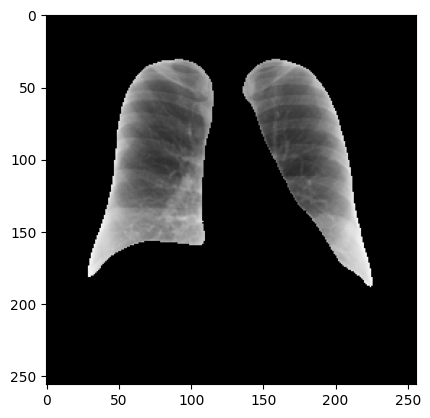

In [52]:
input_img = features[0][38]
plt.imshow(input_img, 'gray')

In [73]:
trans_img = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, )),])

input_img_tensor = trans_img(features[0][38]).unsqueeze(0)
input_img_tensor.shape

torch.Size([1, 1, 256, 256])

In [74]:
occlusion_size = 50
occlusion_stride = 10

In [79]:
from torch.autograd import Variable

def generate_saliency_map(model, input_tensor, target_class=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    input_tensor = input_tensor.to(device)
    # Set the model to evaluation mode
    model.eval()

    # Convert the input tensor to a variable with gradient tracking
    input_var = Variable(input_tensor, requires_grad=True)

    # Forward pass to get the output of the model
    output, _ = model((input_var, input_var))

    if target_class is None:
        # If target_class is not specified, use the class with the highest probability
        target_class = torch.argmax(output, dim=1)

    # Calculate the scalar loss as the mean of the output tensor for the target class
    loss = torch.mean(output[:, target_class])

    # Calculate gradients of the loss with respect to the input
    loss.backward()

    # Get the gradients from the input tensor
    saliency_map = input_var.grad.data

    # Take the absolute value of the gradients to get the magnitude
    saliency_map = torch.abs(saliency_map)

    # Convert the saliency map to a grayscale image
    saliency_map = torch.mean(saliency_map, dim=1, keepdim=True)

    # Normalize the saliency map to the range [0, 1]
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

    # Squeeze the batch dimension if present
    if len(saliency_map.size()) == 4:
        saliency_map = saliency_map.squeeze(0)

    return saliency_map

In [67]:
def visualize_saliency_map(saliency_map):
    # Convert the saliency map tensor to a NumPy array
    saliency_np = saliency_map.squeeze().detach().cpu().numpy()

    # Normalize the saliency map to a scale of 0 to 1
    saliency_np = (saliency_np - saliency_np.min()) / (saliency_np.max() - saliency_np.min())

    # Plot the saliency map as a heatmap
    plt.imshow(saliency_np, cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.show()

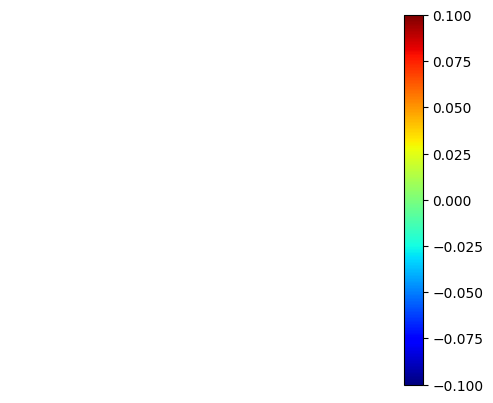

In [80]:
saliency_map = generate_saliency_map(model, input_img_tensor)

# Visualize the saliency map using matplotlib or any other library
visualize_saliency_map(saliency_map)

# Testing Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
anchor = trans_img(df.iloc[4]['masked']).to(device)
same = trans_img(df.iloc[3]['masked']).to(device)
diff1 = trans_img(df.iloc[2]['masked']).to(device)
diff2 = trans_img(df.iloc[1]['masked']).to(device)
diff3 = trans_img(df.iloc[0]['masked']).to(device)

In [ ]:
anchor.unsqueeze(0).shape

torch.Size([1, 1, 256, 256])

In [ ]:
def getPred(x1, x2, model):
  x1 = x1.unsqueeze(0)
  x2 = x2.unsqueeze(0)
  dist1, dist2 = model((x1, x2))
  return float(F.pairwise_distance(dist1, dist2)[0].detach().cpu().numpy())

In [ ]:
getPred(anchor, same, model)

1.251429557800293

In [ ]:
getPred(anchor, diff1, model)

1.1246811151504517

In [ ]:
getPred(anchor, diff2, model)

1.1938354969024658

In [ ]:
getPred(anchor, diff3, model)

1.4903411865234375

In [ ]:
getPred(same, diff3, model)

1.8244678974151611

In [ ]:
def printResult(model, anchor=0, comp=1):
  rows = 1
  cols = 2
  fig = plt.figure(figsize=(cols * 2, rows * 2))
  trans_img = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, )),])
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  anchor_img = trans_img(df_100.iloc[anchor]['right']).to(device)
  comp_img = trans_img(df_100.iloc[comp]['right']).to(device)
  print('disimilarity = ', getPred(anchor_img, comp_img, model))
  ax = fig.add_subplot(rows, cols, 1)
  ax.imshow(df_100.iloc[anchor]['right'], 'gray')
  ax.title.set_text(f'extent_right: {df_100.iloc[anchor]["extent_right_numerical"]}')
  ax = fig.add_subplot(rows, cols, 2)
  ax.imshow(df_100.iloc[comp]['right'], 'gray')
  ax.title.set_text(f'extent_right=: {df_100.iloc[comp]["extent_right_numerical"]}')

disimilarity =  9.448935508728027


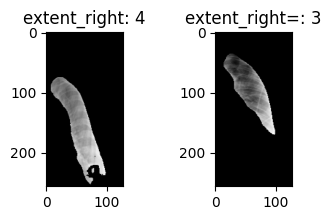

In [ ]:
printResult(model)

disimilarity =  2.8807287216186523


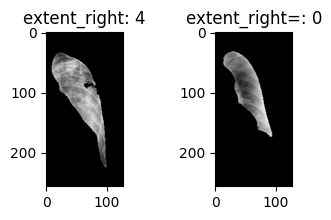

In [ ]:
printResult(model, 50, 71)